## todo
Write down analysis/insights for each song trait, relationship with popularity

https://www.kaggle.com/code/anatpeled/spotify-popularity-prediction

In [1]:
!pip install yellowbrick
!pip install wordcloud

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions for linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Data Prep and Cleaning

In [3]:
allsongs = pd.read_csv('datasets/spotify_dataset.csv', dtype={'song_name': str})

# Information about the Variables
# check for any NULL values
allsongs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41099 entries, 0 to 41098
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41099 non-null  object 
 1   artist            41099 non-null  object 
 2   uri               41099 non-null  object 
 3   danceability      41099 non-null  float64
 4   energy            41099 non-null  float64
 5   key               41099 non-null  int64  
 6   loudness          41099 non-null  float64
 7   mode              41099 non-null  int64  
 8   speechiness       41099 non-null  float64
 9   acousticness      41099 non-null  float64
 10  instrumentalness  41099 non-null  float64
 11  liveness          41099 non-null  float64
 12  valence           41099 non-null  float64
 13  tempo             41099 non-null  float64
 14  duration_ms       41099 non-null  int64  
 15  time_signature    41099 non-null  int64  
 16  chorus_hit        41099 non-null  float6

In [4]:
# Cleaning dataset
allsongs = allsongs.drop(columns = ['uri'])

# drop rows without track name
allsongs = allsongs.dropna(subset=['track'])
allsongs = allsongs.reset_index(drop=True)

# Change decade column to int
allsongs['decade'] = allsongs.decade.str.replace('s' , '')
allsongs['decade'] = pd.to_numeric(allsongs['decade'])

decades = allsongs['decade']
for i, x in enumerate(decades):
    if x >= 60:
        allsongs['decade'][i] += 1900
    if x <= 20:
        allsongs['decade'][i] += 2000

allsongs.head()

/var/folders/8p/z6jpfmkx121g6l5kqwrv7cc80000gn/T/ipykernel_39140/737296203.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allsongs['decade'][i] += 1900
/var/folders/8p/z6jpfmkx121g6l5kqwrv7cc80000gn/T/ipykernel_39140/737296203.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allsongs['decade'][i] += 2000


,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,1960
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,1960
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,1960
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,1960
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,1960


## Exploratory Data Analysis/Visualisation

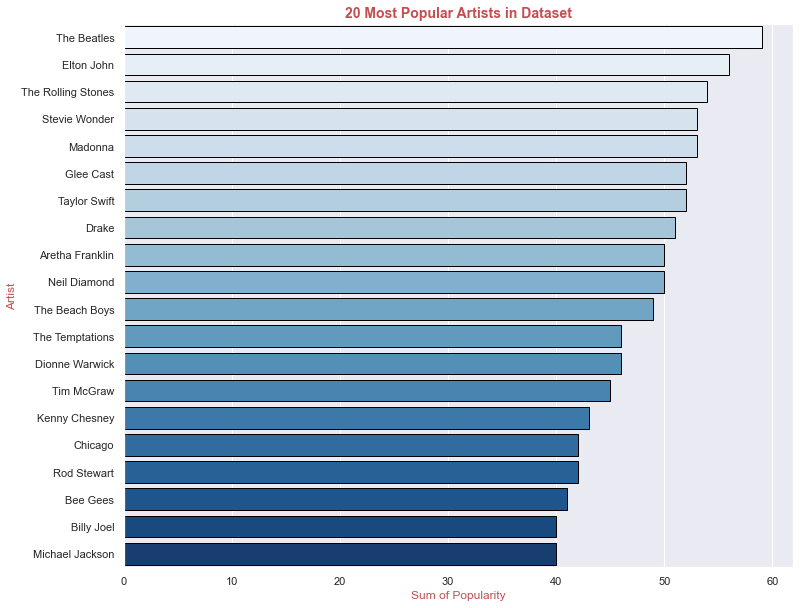

In [5]:
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = allsongs.groupby('artist')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sb.barplot(x=lead_artists.values, y=lead_artists.index, palette="Blues", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

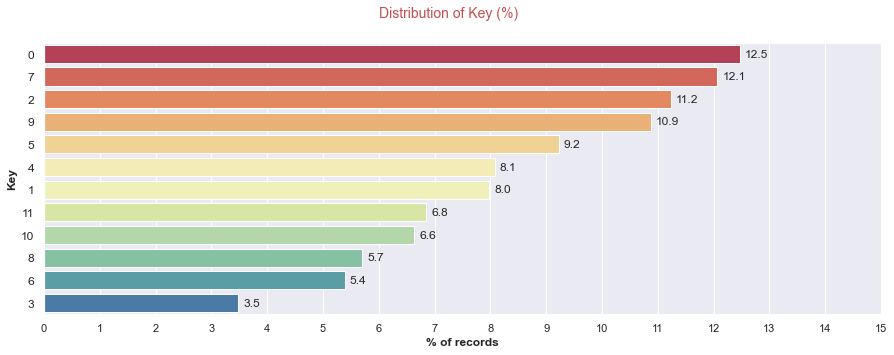

In [6]:
# Distribution of key
fig, ax = plt.subplots(figsize = (15, 5))
key_data = allsongs['key'].value_counts(normalize=True, sort=True, ascending=True)*100
y_ticks = allsongs['key'].value_counts().index
ax = sb.barplot(x = key_data.values, y= y_ticks, data = key_data, orient='h', palette='Spectral')
ax.set_xlabel('% of records', fontsize=12, weight='bold')
ax.set_ylabel('Key', fontsize=12, weight='bold')
ax.set_xlim(0.0,15.0, 0)
ax.set_xticks(ticks=range(0,16,1))
ax.set_yticklabels(labels=y_ticks, fontsize=12) #

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width() #f'{rect.get_width():.2f}'
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = f'{x_value:.1f}'

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.suptitle('Distribution of Key (%)', fontsize=14, c='r')
plt.show()

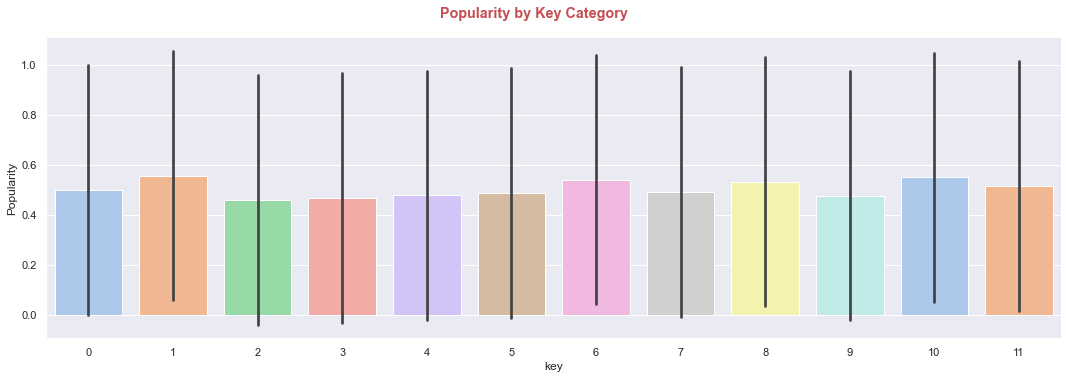

In [7]:
exp_data = sb.catplot(data=allsongs, kind="bar",
                        x="key", y="popularity",
                        palette='pastel',
                        ci = 'sd',
                        height=5, aspect = 3)
exp_data.fig.suptitle('Popularity by Key Category', y=1.05, c='r', weight='bold')
exp_data.set_axis_labels("key", "Popularity")
plt.show()

## Song Traits

key — The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. Ex: 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

Mode — Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

Acoustiness — A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

Danceability — Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is the most danceable.

Energy — Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

Instrumentalness — Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

Loudness — The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 dB.

Valence — A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive.

Tempo — The overall estimated tempo of a track in beats per minute (BPM).

Popularity — The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.


In [8]:
songtraits = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "chorus_hit", "sections", "decade"]

In [9]:
# allsongs['duration_ms'].corr(allsongs['popularity'])
series = np.abs(corr['popularity']).sort_values(ascending=False)

print('The most linearly correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.11 <= row < 1:
      print(f'{series.index[i]:18} -> {row: .3f} (abs)')

NameError: name 'corr' is not defined

In [ ]:
from yellowbrick.target import FeatureCorrelation

X, y = allsongs[songtraits], allsongs['popularity']

#list of songtraits
traits = np.array(songtraits)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=traits)

plt.rcParams['figure.figsize']=(10,10)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  

In [ ]:
# Splitting dataset into popular and non-popular songs
popular = allsongs[allsongs['popularity'] == 1]
notpopular = allsongs[allsongs['popularity'] == 0]

In [ ]:
# Numeric Heatmap
numeric_columns = allsongs.columns[allsongs.dtypes != 'object']
numeric_df = pd.DataFrame(data=allsongs, columns=numeric_columns, index=allsongs.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sb.color_palette("magma")
sb.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

#### Statistical Summary of The Most Linearly Correlated Features

In [ ]:
# Extract variables
LC_features = pd.DataFrame(allsongs[["instrumentalness", "danceability", "loudness", "valence", "acousticness", "energy"]])

# Summary Statistics
LC_features.describe().round(2)

## Instrumentalness
The closer to 1, the lesser the vocals

Most songs are very close to 0, but there's a small number of songs around 0.9

In [ ]:
fig, ax = plt.subplots(figsize = (15,3))
ax = sb.histplot(allsongs['instrumentalness'], kde = False, bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('instrumentalness')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='instrumentalness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is the most danceable.

Normal distribution around 0.6, clear relationship with popularity of songs despite some outliers, higher danceability = more popular

In [ ]:
sb.displot(allsongs['danceability'], kde=False, bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('danceability')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='danceability', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Loudness
Maybe dont use this cos popularity only 0 or 1

In [ ]:
#fig, ax = plt.subplots(figsize = (15, 6))
#sb.scatterplot(x='loudness', y='popularity', data=allsongs, color='blue', alpha=0.3)
#plt.show()

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('loudness')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='loudness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('loudness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#todo Bar graph for loudness (for popular and non-popular songs)

## Valence
Maybe don't use this also

In [ ]:
#sb.jointplot(x='valence', y='popularity', data=allsongs)
#plt.show()

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('valence')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='valence', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('valence')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

The majority of acousticness of songs is close to 0. There is a slight negative relationship between acousticness and popularity

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
sb.histplot(allsongs['acousticness'], kde=False, bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  allsongs.groupby('acousticness')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x = ax1_data['acousticness'], y = ax1_data['popularity'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

Most popular songs seem to be around 0.6 - 0.8

In [ ]:
sb.displot(allsongs['energy'], kde = False, bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  allsongs.groupby('energy')['popularity'].mean().to_frame().reset_index()
ax = sb.scatterplot(x='energy', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('energy')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

## Machine learning techniques to solve specific problem
### Problem: Can we predict whether a song will be popular given statistics of the song traits?

### comments
-maybe add swarmplot for more illustration

-classification tree changes each time the row is run due to random train test split

-could change max depth of tree to get higher accuracy, but makes the tree hard to see

In [ ]:
# Import essential models and functions for classifcation tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

popular = pd.DataFrame(allsongs['popularity'])  # Response

In [ ]:
def univar_tree(predictor):
    predictor = pd.DataFrame(allsongs[predictor])  
    
    X_train, X_test, y_train, y_test = train_test_split(predictor, popular, test_size = 0.2)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
    dectree.fit(X_train, y_train)                    # train the decision tree model
    
    #plot tree
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree, filled=True, rounded=True, 
        feature_names=["predictor"], 
        class_names=["unpopular","popular"])

In [ ]:
def accuracy(predictor):
    predictor = pd.DataFrame(allsongs[predictor])  
    
    X_train, X_test, y_train, y_test = train_test_split(predictor, popular, test_size = 0.2)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
    dectree.fit(X_train, y_train)                    # train the decision tree model
    
    # Predict Legendary values corresponding to Total
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [ ]:
univar_tree('danceability')

In [ ]:
accuracy('danceability')

In [ ]:
univar_tree('acousticness')

In [ ]:
accuracy('acousticness')

In [ ]:
univar_tree('energy')

In [ ]:
accuracy('energy')

---

## Multi-Variate Classification Tree  

Response Variable : **popularity**     
Predictor Feature : **danceability, acousticness, energy**       


In [ ]:
# Extract Response and Predictors
# popular is name of dataframe for popularity (already created above)
combination = pd.DataFrame(allsongs[["danceability", "acousticness", "energy"]])

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(combination, popular, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

In [ ]:
# Draw the distributions of all Predictors
f, axes = plt.subplots(3, 3, figsize=(18, 16))

count = 0
for var in X_train:
    sb.boxplot(data = X_train[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_train[var], ax = axes[count,1])
    sb.violinplot(data = X_train[var], orient = "h", ax = axes[count,2])
    count += 1

In [ ]:
# Decision Tree using Train Data
dectree1 = DecisionTreeClassifier(max_depth = 3)  # create the decision tree object
dectree1.fit(X_train, y_train)                    # train the decision tree model

f = plt.figure(figsize=(12,12))
plot_tree(dectree1, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["unpopular","popular"])

In [ ]:
# Predict popularity corresponding to combination of predictors
y_train_pred = dectree1.predict(X_train)
y_test_pred = dectree1.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree1.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree1.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

## trying out random forest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
#popular = pd.DataFrame(allsongs['popularity'])  # Response
df_mod = pd.DataFrame(allsongs[["instrumentalness", "danceability", "loudness", "valence", "acousticness", "energy"]])

In [ ]:
x_train,x_test,y_train, y_test = train_test_split(df_mod, popular,test_size=0.2,random_state=27)

In [ ]:
random_forest = RandomForestRegressor()

random_forest.fit(x_train, y_train)
Y_pred_rf = random_forest.predict(x_test)
random_forest.score(x_train,y_train)
acc_random_forest = round(random_forest.score(x_train,y_train) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_,x_train.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

In [ ]:
#r squared value
r_sq = metrics.r2_score(y_test, Y_pred_rf)
print(r_sq)

## Other Stuff

In [ ]:
from wordcloud import WordCloud
plt.style.use('seaborn')
decade10 = popular[popular['decade'] == 2010]
words = decade10["artist"].str.split("(").str[0].value_counts().keys()

wc1 = WordCloud(scale=5,max_words=1000,colormap="rainbow",background_color="white").generate(" ".join(words))
plt.figure(figsize=(12,18))
plt.imshow(wc1,interpolation="bilinear")
plt.axis("off")
plt.title("Artist Name for top 50 songs in the 2010s", color='b')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(20, 10))
sb.despine(fig, left=True, bottom=True)
sb.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})

columns = ["acousticness", "danceability", "energy", "speechiness", "liveness", "valence"]

for col in columns:
    x = allsongs.groupby("decade")[col].mean()
    ax= sb.lineplot(x=x.index,y=x,label=col)
ax.set_title('Audio characteristics over the decades')
ax.set_ylabel('Measure')
ax.set_xlabel('Year')